In [6]:
import numpy as np # linear algebra
import scipy as scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import dill

import keras as k
import cv2
from tqdm import tqdm


Using Theano backend.


In [7]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)
x_train = np.array(all_info[0], dtype=np.float64)
x_test = np.array(all_info[1], dtype=np.float64)
y_train = all_info[2]
y_test = all_info[3]
label_map = all_info[4]
inv_label_map = all_info[5]
print(x_train.shape)

(35000, 32, 32, 4)


In [8]:
from skimage import feature

def getEdges(a):
    red_lst = list()
    green_lst = list()
    blue_lst = list()
    nir_lst = list()
    for i, image in enumerate(a):
        if i % 10000 == 0:
            print(i)
        red_lst.append(feature.canny(image[:,:,0], sigma=3))
        green_lst.append(feature.canny(image[:,:,1], sigma=3))
        blue_lst.append(feature.canny(image[:,:,2], sigma=3))
        nir_lst.append(feature.canny(image[:,:,3], sigma=3))
    temp = np.array([red_lst, green_lst, blue_lst, nir_lst])
    return temp.reshape((temp.shape[1], temp.shape[2], temp.shape[3], temp.shape[0]))

train_edges = getEdges(x_train)
test_edges = getEdges(x_test)
print(train_edges.shape)

0
10000
20000
30000
0
(35000, 32, 32, 4)


In [9]:
mean = np.mean(x_train, axis = 0)
x_train -= mean # zero-center
x_test -= mean
std = np.std(x_train, axis = 0)
x_train /= std # normalize
x_test /= std

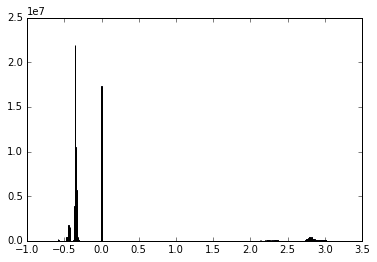

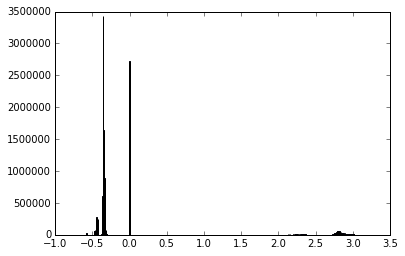

In [10]:
edge_mean = np.mean(train_edges, axis = 0)
train_edges = np.subtract(train_edges, edge_mean, casting="unsafe") # zero-center
test_edges = np.subtract(test_edges, edge_mean, casting="unsafe") # zero-center
edge_std = np.std(train_edges, axis = 0)
train_edges /= edge_std # normalize
test_edges /= edge_std

train_edges = np.nan_to_num(train_edges)
test_edges = np.nan_to_num(test_edges)

import matplotlib.pyplot as plt
hist, bins = np.histogram(train_edges, bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

hist, bins = np.histogram(test_edges, bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

Extracting features for x_train

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam

#baseline part
original_input = Input(shape=(32, 32, 4))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(original_input)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
max1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop1 = Dropout(0.25)(max1)
flat1 = Flatten()(drop1)
dense1 = Dense(128, activation='relu')(flat1)
drop2 = Dropout(0.5)(dense1)

edge_input = Input(shape=(32, 32, 4))
drop3 = Dropout(0.25)(edge_input)
flat2 = Flatten()(drop3)

combine = concatenate([drop2, flat2])
dense3 = Dense(256, activation='relu')(combine)
drop4 = Dropout(0.5)(dense3)
dense4 = Dense(17, activation='sigmoid', name='test')(drop4)



model = Model(inputs=[original_input, edge_input], outputs=dense4)

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                    optimizer='adam',
                    metrics=['accuracy'])

model.fit([x_train, train_edges], y_train, batch_size=128, 
          epochs=7, verbose=1, validation_data=([x_test, test_edges], y_test))

from sklearn.metrics import fbeta_score

p_valid = model.predict([x_test, test_edges], batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

Train on 35000 samples, validate on 5479 samples
Epoch 1/7
35000/35000 [==============================] - 278s - loss: 0.2718 - acc: 0.8969 - val_loss: 0.2074 - val_acc: 0.9209
Epoch 2/7
35000/35000 [==============================] - 269s - loss: 0.2003 - acc: 0.9231 - val_loss: 0.1796 - val_acc: 0.9296
Epoch 3/7
35000/35000 [==============================] - 272s - loss: 0.1741 - acc: 0.9331 - val_loss: 0.1696 - val_acc: 0.9352
Epoch 4/7
35000/35000 [==============================] - 286s - loss: 0.1588 - acc: 0.9392 - val_loss: 0.1625 - val_acc: 0.9390
Epoch 5/7
35000/35000 [==============================] - 302s - loss: 0.1471 - acc: 0.9433 - val_loss: 0.1595 - val_acc: 0.9403
Epoch 6/7
35000/35000 [==============================] - 284s - loss: 0.1370 - acc: 0.9469 - val_loss: 0.1580 - val_acc: 0.9403
Epoch 7/7
35000/35000 [==============================] - 263s - loss: 0.1294 - acc: 0.9495 - val_loss: 0.1568 - val_acc: 0.9414
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 1 ..., 0 